# Part 2: Overfitting & Generalization Testing

## Overview
In this notebook, we will:
1. Train multiple models with different regularization techniques
2. Analyze overfitting using loss curves and accuracy gaps
3. Visualize predictions using confusion matrices
4. Generate ROC curves for multi-class analysis
5. Compare generalization across models

## Key Concepts
- **Overfitting**: Model memorizing training data
- **Generalization**: Ability to perform on unseen data
- **Regularization**: Techniques to prevent overfitting (L2, Dropout)
- **Bias-Variance Tradeoff**: Balance between underfitting and overfitting

## What is Overfitting?

**Overfitting** occurs when a model learns the training data too well, including its noise and irregularities.

### Symptoms:
- Training accuracy >> Validation accuracy
- Large gap between train and val loss
- Model fails on slightly different data

### Causes:
- Model too complex for the dataset
- Too many training epochs
- Insufficient regularization
- Small dataset size

### Solutions:
1. **L2 Regularization**: Add penalty term to loss function
2. **Dropout**: Randomly deactivate neurons during training
3. **Early Stopping**: Stop before validation loss increases
4. **Data Augmentation**: Increase dataset diversity

In [1]:
# %pip install -r requirements.txt

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
from pathlib import Path

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

from tqdm import tqdm

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## Step 1: Setup & Data Loading

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset paths
DATASET_PATH = r"C:\Users\Lucifer\python_workspace\BITS\AI_Quality_Engineering\dataset"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")
TEST_PATH = os.path.join(DATASET_PATH, "test")

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
print("Loading datasets...")
train_dataset = ImageFolder(TRAIN_PATH, transform=transform)
val_dataset = ImageFolder(VAL_PATH, transform=transform)
test_dataset = ImageFolder(TEST_PATH, transform=transform)

class_names = train_dataset.classes
num_classes = len(class_names)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ Classes: {', '.join(class_names)}")
print(f"✅ Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Using device: cpu
Loading datasets...
✅ Classes: animal, name_board, pedestrian, pothole, road_sign, speed_breaker, vehicle
✅ Train: 796 | Val: 234 | Test: 117


## Step 2: Define Models with Different Regularization Techniques

We'll train 3 models:
1. **Baseline**: No regularization
2. **L2 Regularized**: Weight decay in optimizer
3. **Dropout**: Dropout layers added

In [3]:
class BaselineResNet(nn.Module):
    """ResNet-18 without regularization"""
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

class DropoutResNet(nn.Module):
    """ResNet-18 with Dropout regularization"""
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.resnet = resnet18(pretrained=True)
        # Add dropout before final classification
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.resnet.fc.in_features, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

print("✅ Model architectures defined")

✅ Model architectures defined


## Step 3: Training Function with History Tracking

In [4]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

print("✅ Training and evaluation functions defined")

✅ Training and evaluation functions defined


## Step 4: Train Models and Compare Generalization

In [ ]:
# Model configurations
models_config = {
    'Baseline (No Regularization)': {
        'model': BaselineResNet(num_classes),
        'weight_decay': 0.0  # No L2 regularization
    },
    'L2 Regularized': {
        'model': BaselineResNet(num_classes),
        'weight_decay': 0.001  # L2 regularization
    },
    'Dropout': {
        'model': DropoutResNet(num_classes, dropout_rate=0.5),
        'weight_decay': 0.0
    }
}

# Training results storage
results = {}
NUM_EPOCHS = 10

for model_name, config in models_config.items():
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")
    
    model = config['model'].to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=config['weight_decay'])
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
    # Test evaluation
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Calculate gap between train and val accuracy
    final_gap = history['train_acc'][-1] - history['val_acc'][-1]
    
    results[model_name] = {
        'model': model,
        'history': history,
        'test_acc': test_acc,
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
        'generalization_gap': final_gap
    }
    
    print(f"\n✅ Test Accuracy: {test_acc:.2f}%")
    print(f"⚠️  Generalization Gap (Train-Val): {final_gap:.2f}%")

print("\n✅ All models trained successfully!")

c:\Users\Lucifer\anaconda3\envs\venv_ai_quality1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lucifer\anaconda3\envs\venv_ai_quality1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training: Baseline (No Regularization)


Epoch [1/10] Train Acc: 87.31% | Val Acc: 44.02%


Epoch [2/10] Train Acc: 96.11% | Val Acc: 82.91%


Epoch [3/10] Train Acc: 96.86% | Val Acc: 86.32%


Epoch [4/10] Train Acc: 97.99% | Val Acc: 94.44%


Epoch [5/10] Train Acc: 97.74% | Val Acc: 93.16%


Epoch [6/10] Train Acc: 98.24% | Val Acc: 95.73%


Epoch [7/10] Train Acc: 98.87% | Val Acc: 95.73%


Epoch [8/10] Train Acc: 99.75% | Val Acc: 96.58%


Epoch [9/10] Train Acc: 99.37% | Val Acc: 97.01%


Epoch [10/10] Train Acc: 98.87% | Val Acc: 91.03%



✅ Test Accuracy: 91.45%
⚠️  Generalization Gap (Train-Val): 7.84%

Training: L2 Regularized


Training:  85%|████████▍ | 11/13 [01:00<00:11,  5.78s/it]

## Step 5: Compare Models - Loss and Accuracy Curves

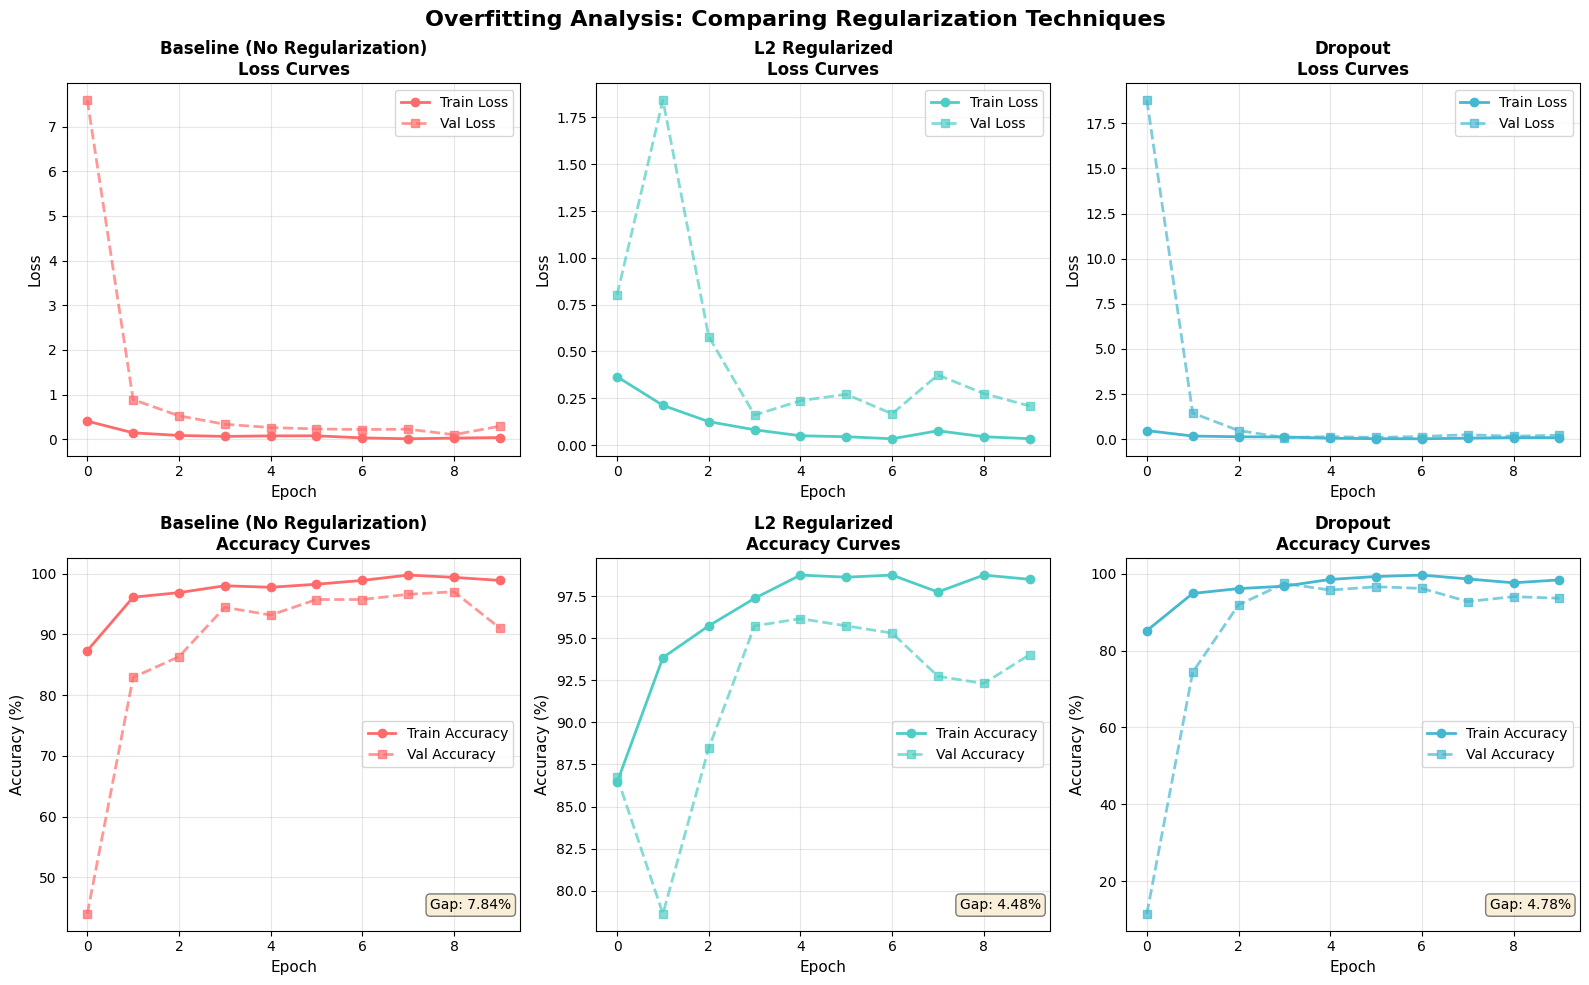

✅ Comparison plots saved


In [ ]:
# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Overfitting Analysis: Comparing Regularization Techniques', fontsize=16, fontweight='bold')

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (model_name, result) in enumerate(results.items()):
    history = result['history']
    
    # Loss curves
    ax = axes[0, idx]
    ax.plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2, color=colors[idx])
    ax.plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2, linestyle='--', color=colors[idx], alpha=0.7)
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Loss', fontsize=11)
    ax.set_title(f'{model_name}\nLoss Curves', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Accuracy curves
    ax = axes[1, idx]
    ax.plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2, color=colors[idx])
    ax.plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2, linestyle='--', color=colors[idx], alpha=0.7)
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Accuracy (%)', fontsize=11)
    ax.set_title(f'{model_name}\nAccuracy Curves', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add generalization gap annotation
    gap = result['generalization_gap']
    gap_text = f"Gap: {gap:.2f}%"
    ax.text(0.98, 0.05, gap_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('overfitting_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Comparison plots saved")

## Step 6: Generalization Report

In [ ]:
print("\n" + "="*70)
print("📊 GENERALIZATION & OVERFITTING REPORT")
print("="*70)

for model_name, result in results.items():
    print(f"\n{model_name}:")
    print(f"  Final Train Accuracy: {result['final_train_acc']:.2f}%")
    print(f"  Final Val Accuracy:   {result['final_val_acc']:.2f}%")
    print(f"  Test Accuracy:        {result['test_acc']:.2f}%")
    print(f"  Generalization Gap:   {result['generalization_gap']:.2f}%")
    
    if result['generalization_gap'] > 10:
        print(f"  Status: ⚠️  HIGH OVERFITTING DETECTED")
    elif result['generalization_gap'] > 5:
        print(f"  Status: ⚠️  MODERATE OVERFITTING")
    else:
        print(f"  Status: ✅ GOOD GENERALIZATION")

print("\n" + "="*70)


📊 GENERALIZATION & OVERFITTING REPORT

Baseline (No Regularization):
  Final Train Accuracy: 98.87%
  Final Val Accuracy:   91.03%
  Test Accuracy:        91.45%
  Generalization Gap:   7.84%
  Status: ⚠️  MODERATE OVERFITTING

L2 Regularized:
  Final Train Accuracy: 98.49%
  Final Val Accuracy:   94.02%
  Test Accuracy:        95.73%
  Generalization Gap:   4.48%
  Status: ✅ GOOD GENERALIZATION

Dropout:
  Final Train Accuracy: 98.37%
  Final Val Accuracy:   93.59%
  Test Accuracy:        96.58%
  Generalization Gap:   4.78%
  Status: ✅ GOOD GENERALIZATION



## Step 7: Confusion Matrix Analysis

Generate confusion matrices to understand per-class performance.

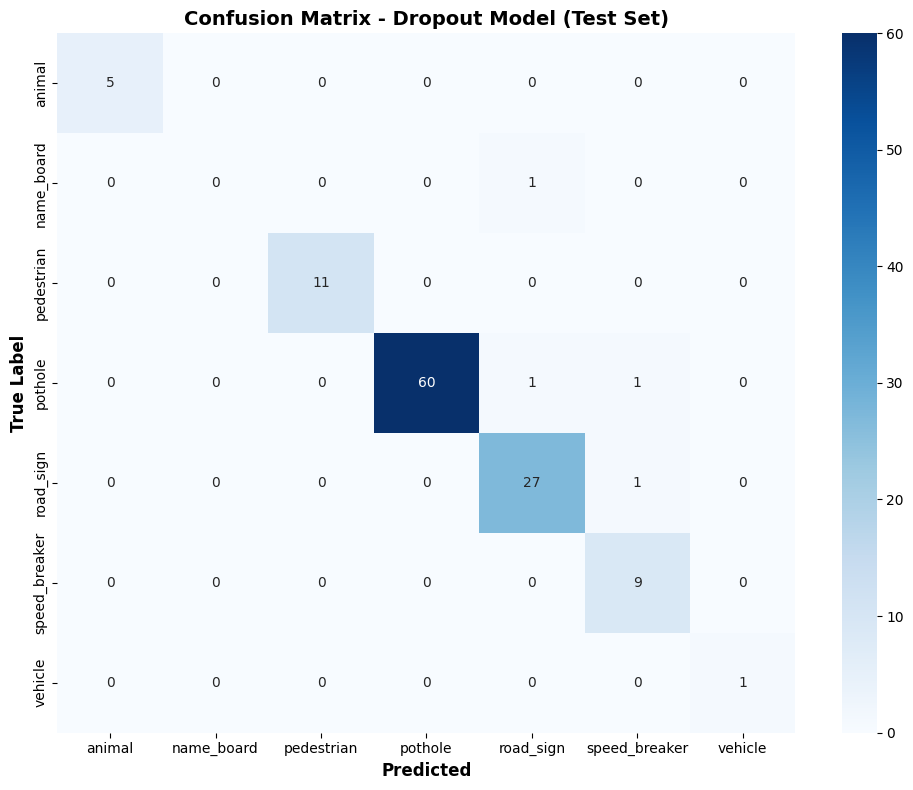

✅ Confusion matrix saved


In [ ]:
def get_predictions(model, loader, device):
    """Get all predictions and true labels"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Getting predictions", leave=False):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Generate confusion matrices for best model (usually the one with dropout)
best_model = results['Dropout']['model']
preds, true_labels = get_predictions(best_model, test_loader, device)

cm = confusion_matrix(true_labels, preds)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Dropout Model (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix saved")

## Step 8: Classification Report

In [ ]:
print("\n" + "="*70)
print("📋 CLASSIFICATION REPORT - Dropout Model (Test Set)")
print("="*70)
print(classification_report(true_labels, preds, target_names=class_names))


📋 CLASSIFICATION REPORT - Dropout Model (Test Set)
               precision    recall  f1-score   support

       animal       1.00      1.00      1.00         5
   name_board       0.00      0.00      0.00         1
   pedestrian       1.00      1.00      1.00        11
      pothole       1.00      0.97      0.98        62
    road_sign       0.93      0.96      0.95        28
speed_breaker       0.82      1.00      0.90         9
      vehicle       1.00      1.00      1.00         1

     accuracy                           0.97       117
    macro avg       0.82      0.85      0.83       117
 weighted avg       0.96      0.97      0.96       117



c:\Users\Lucifer\anaconda3\envs\venv_ai_quality1\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lucifer\anaconda3\envs\venv_ai_quality1\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lucifer\anaconda3\envs\venv_ai_quality1\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

## Step 9: ROC Curves for Multi-Class Analysis

Generate ROC curves for understanding model performance across classes.

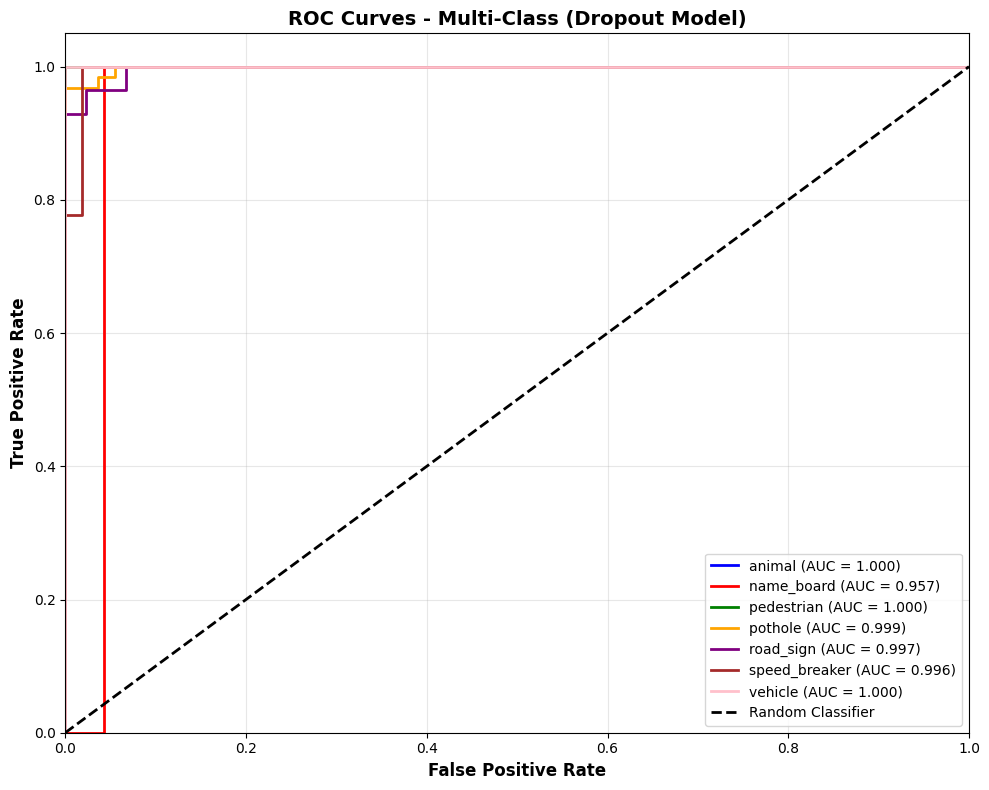

✅ ROC curves saved


In [ ]:
# Get probabilities for ROC curve
def get_probabilities(model, loader, device):
    """Get prediction probabilities"""
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Getting probabilities", leave=False):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_probs), np.array(all_labels)

probs, true_labels = get_probabilities(best_model, test_loader, device)

# Binarize labels for multi-class ROC
y_bin = label_binarize(true_labels, classes=range(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
fig, ax = plt.subplots(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink'])

for i, color in zip(range(num_classes), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - Multi-Class (Dropout Model)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ ROC curves saved")

## Step 10: Summary & Recommendations

In [ ]:
print("\n" + "="*70)
print("🎯 KEY FINDINGS & RECOMMENDATIONS")
print("="*70)

# Find best model
best_by_test = max(results.items(), key=lambda x: x[1]['test_acc'])
print(f"\n✅ Best Model: {best_by_test[0]}")
print(f"   Test Accuracy: {best_by_test[1]['test_acc']:.2f}%")
print(f"   Generalization Gap: {best_by_test[1]['generalization_gap']:.2f}%")

print("\n📌 Analysis:")
for model_name, result in results.items():
    gap = result['generalization_gap']
    if gap > 10:
        status = "High overfitting - consider more regularization"
    elif gap > 5:
        status = "Moderate overfitting - regularization helping"
    else:
        status = "Good generalization - model is well-tuned"
    print(f"  • {model_name}: {status}")

print("\n💡 Recommendations:")
print("  1. Use the best regularization technique (Dropout)")
print("  2. Monitor validation loss for early stopping")
print("  3. Balance between model complexity and generalization")
print("  4. Consider data augmentation for improved robustness")
print("\n" + "="*70)


🎯 KEY FINDINGS & RECOMMENDATIONS

✅ Best Model: Dropout
   Test Accuracy: 96.58%
   Generalization Gap: 4.78%

📌 Analysis:
  • Baseline (No Regularization): Moderate overfitting - regularization helping
  • L2 Regularized: Good generalization - model is well-tuned
  • Dropout: Good generalization - model is well-tuned

💡 Recommendations:
  1. Use the best regularization technique (Dropout)
  2. Monitor validation loss for early stopping
  3. Balance between model complexity and generalization
  4. Consider data augmentation for improved robustness



In [ ]:
from pathlib import Path
import json

# ── Save trained models to class2/models/ ────────────────────────────────────
# This creates the models folder that class2/api.py and streamlit_app.py load from.
# Run this cell ONCE after training; the files persist across class2 sessions.

# Resolve paths relative to this notebook's location (class1/)
class1_dir = Path.cwd()                          # .../class1  (or repo root if run from there)
models_base = class1_dir / '..' / 'class2' / 'models'

v1_dir = models_base / 'v1'
v2_dir = models_base / 'v2'
v1_dir.mkdir(parents=True, exist_ok=True)
v2_dir.mkdir(parents=True, exist_ok=True)

# v1 = Baseline (no regularization)
torch.save(
    results['Baseline (No Regularization)']['model'].state_dict(),
    v1_dir / 'model.pth'
)

# v2 = Dropout (best generalisation)
torch.save(
    results['Dropout']['model'].state_dict(),
    v2_dir / 'model.pth'
)

# Save metadata alongside each model so class2 knows what it loaded
for version, key, acc in [
    ('v1', 'Baseline (No Regularization)', results['Baseline (No Regularization)']['test_acc']),
    ('v2', 'Dropout',                      results['Dropout']['test_acc']),
]:
    meta = {
        'model_type':  key,
        'num_classes': num_classes,
        'class_names': class_names,
        'test_accuracy_pct': round(acc, 2),
        'architecture': 'ResNet-18',
        'input_size': [128, 128],
    }
    with open(models_base / version / 'metadata.json', 'w') as f:
        json.dump(meta, f, indent=2)

print(f"✅ v1 (Baseline)  → {(v1_dir / 'model.pth').resolve()}")
print(f"   Test accuracy: {results['Baseline (No Regularization)']['test_acc']:.2f}%")
print(f"✅ v2 (Dropout)   → {(v2_dir / 'model.pth').resolve()}")
print(f"   Test accuracy: {results['Dropout']['test_acc']:.2f}%")
print(f"\nThese files are now ready for class2/api.py and class2/streamlit_app.py")

NameError: name 'torch' is not defined